## Import packages

In [1]:
import CairoMakie: activate!, Figure, Axis, save, lines!, scatter!, lines, scatter, scatterlines!, 
hlines!, vlines!, axislegend, Legend, series, series!, Theme, set_theme!, cgrad, band!, 
xlims!, ylims!, contourf!, Colorbar, hist, hist!, contour!, heatmap!, text!, rowgap!, colgap!,
hist, qqplot!, qqnorm!, density!, Relative, rowsize!, colsize!, Outside,
poly!, hidedecorations!, hidespines!, Label, text!, AxisAspect, GridLayout, Outside, colsize!, rowsize!, Relative, AxisAspect, 
density!, qqplot!, linkxaxes!, linkyaxes!, BBox, translate!, TopLeft, Label, resize_to_layout!,
hidexdecorations!, hideydecorations!, Inside, Outside, Aspect, Observable, notify
import Makie: pseudolog10
import Makie: available_gradients
import Measures: mm
import StatsBase: sample, mean, min, mode, max, sample, fit, Histogram, std, quantile, median, skewness, kurtosis
using Distributed
import DataFrames: DataFrame, names, describe, append!, insertcols!, hcat!, groupby, combine
import JLD: save, load
import CSV: write, read, File
import CurveFit: curve_fit, Polynomial
import Calculus: derivative
import Roots: find_zero, fzero, newton, Newton
#import ForwardDiff: derivative 
import NLsolve: nlsolve
import NaNStatistics: nanmean, nanstd, nanmaximum, nanminimum, nanmax, nanmedian
import Statistics: cor
import Distributions: Normal, cdf, ccdf
import LinearAlgebra: norm, dot, normalize!, normalize
import KernelDensity: kde, extrema, pdf
import Distributions: Normal

using ProgressMeter
#ENV["DATAFRAMES_ROWS"] = 5
import Plots: palette
c=palette(:default); #c = [palette(:tab10)[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
c = [c[1]; c[3]; c[2]; [c[i] for i in 4:length(c)]]; #reorder colors
colblue=palette(:default)[1];
#c=palette(:tab10); c = [c[1]; c[3]; c[4];c[5]; c[2]; [c[i] for i in 6:length(c)]]; #reorder colors
activate!() #activates the Makie backend
set_theme!(Theme(
    fontsize = 10,
    palette  = (color = cgrad(c,length(c)),),
    Lines    = (cycle = [:color],), 
    band     = (cycle = [:color],),
    hlines   = (cycle = [:color],),
    vlines   = (cycle = [:color],),
    scatter  = (cycle = [:color],),
    scatterlines = (cycle = [:color],),
    series   = (cycle = [:color],),
    colormap = cgrad(:default),   #sunset,    # CMRmap  gnuplot magma plasma   thermal   linear_bmy_10_95_c78_n256 linear_bmy_10_95_c71_n256
    #Axis=(yticklabelsize=18, xticklabelsize=18,xlabelsize=20,ylabelsize=20),
    #Axis=(titlesize=24,),
    ))

## Phase transition lines

In [2]:
dT = 0.001; Tblue_max = 0.5;
Tblue = dT:dT:Tblue_max;
Fblue(T) = T*acosh((1-T)/T);
ηblue = Fblue.(Tblue);
Tbluemax = Tblue[findmax(ηblue)[2]]; ηbluemax = findmax(ηblue)[1];

findnearest(t, A::AbstractArray) = findmin(abs.(A.-t))[2];
findnearest(vec::AbstractArray, A::AbstractArray) = findnearest.(vec, Ref(A));

nanlength(x::AbstractArray) = sum(.~isnan.(x));
nanse(x::AbstractArray) = nanstd(x) / sqrt(nanlength(x));

function find_redline(T)  
    fv(T, η, v) = -v + 0.5*sinh(2*v/T)/(cosh(2*v/T) + cosh(η/T));
    dfdv_v(T, x) = [fv(T, x[1], x[2])
                    derivative(v -> fv(T, x[1], v), x[2])];
    xguess(T) = [1-T, 0.5 - T/8];
    return T < 0.0029 ? NaN : try nlsolve(x -> dfdv_v(T, x), xguess(T)).zero[1] catch y NaN end
end

FV(    T, η, V) = 1/2*sinh(2*V/T) / (cosh(2*V/T) + cosh(η/T)) - V;
dFdV(  T, η, V) = derivative(V->FV(T, η, V), V)
d2FdV2(T, η, V) = derivative(V->dFdV(T, η, V), V)
d3FdV3(T, η, V) = derivative(V->d2FdV2(T, η, V), V)

function find_3crit_point()
    #T, eta, V
    find_3crit(x) = [FV(x[1], x[2], x[3]), dFdV(x[1], x[2], x[3]), d3FdV3(x[1], x[2], x[3])];
    xguess = [0.32, Fblue(0.32), 0];
    critpoint = nlsolve(x -> find_3crit(x), xguess).zero;  
    Tcritpoint=critpoint[1]; ηcritpoint=critpoint[2]; Vcritpoint=critpoint[3];
    return Tcritpoint, ηcritpoint
end
function find_redline_full(Tred)
    Tcritpoint = find_3crit_point()[1];
    dV_redcrit = 10^(-2);
    #red line
    dfdv_v_redcritline(T, x) = [FV(T, x[1], x[2]), dFdV(T, x[1], x[2])];
    xguess_redcritline1(T) = [find_redline(T), 0.5 - T/8];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline1(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];  Tsol = Tred; 
    Tsol, etasol, vsol = Tsol[vsol .> dV_redcrit], etasol[vsol .> dV_redcrit], vsol[vsol .> dV_redcrit];
    xguess_redcritline(T) = [find_redline(T), vsol[findnearest(T, Tsol)]];
    xsol = [nlsolve(x -> dfdv_v_redcritline(T, x), xguess_redcritline(T)).zero for T in Tred];
    etasol = [el[1] for el in xsol];   vsol = [el[2] for el in xsol];
    ηred = etasol;
    return ηred
end

Tcritpoint, ηcritpoint = find_3crit_point()
Tred = Tblue[0.003 .≤ Tblue .≤ Tcritpoint];
ηred = find_redline_full(Tred);
Tcritpoint, ηcritpoint 

(0.3333333346990391, 0.4389859650747112)

## Load results from IIM simulations

In [3]:
L = 40; # 40 10 100
IC = "ZERO"; #ZERO, RAND
ic = lowercase(IC);
file_name="./03_data_IIM_simulations/IIM1D_$(IC)_error_rt_vel_etas_0.0_1.0_Ts_0.01_0.85_bias_0.0_2.28_L_$(L)_iter_3000_234000"
df_raw = DataFrame(File(file_name*".csv"));
etas = sort(unique(df_raw.eta))[1:2:end]; # we take etas = 0:0.02:1
Ts   = sort(unique(df_raw.T))[2:2:end];   # we take Ts = 0.02:0.02:0.64
Tmax = 0.64; Ts = Ts[Ts .≤ Tmax];
println(size(df_raw))
df_raw = df_raw[(df_raw.eta .∈ Ref(etas)) .&& (df_raw.T .∈ Ref(Ts)), :];
println(size(df_raw))
println(names(df_raw))

(885753, 15)
(411720, 15)
["eta", "T", "bias", "error", "rt", "rt_cw", "rt_cor", "rt_error", "Vmode", "Vmean", "Vmode_cor", "Vmean_cor", "Vmode_error", "Vmean_error", "iterations"]


## Heatmap of Error rate, mean RT, RTc/RTw for a fixed evidence ϵ1

In [4]:
ϵ1 = 0.01; dϵ1 = 0.002; #we fix the evidence ϵ1 (also called bias) with a small tolerance dϵ1

df_bias = df_raw[abs.(df_raw.bias .- ϵ1) .<= dϵ1, :];
etas = sort(Array(unique(df_bias.eta)));
Ts = sort(Array(unique(df_bias.T)));

## from the data, we extract the mean error, mean RT, and mean RTc/RTw for each (T, η) pair to plot the heaptmaps
error_hmap = fill(NaN, length(Ts), length(etas));
rt_hmap    = fill(NaN, length(Ts), length(etas));
rtcw_hmap  = fill(NaN, length(Ts), length(etas));

@showprogress for (ind_η, η) in enumerate(etas)
    for (ind_T, T) in enumerate(Ts)
        df_eta_T_bias = df_bias[(df_bias.eta .== η) .& (df_bias.T .== T), :];

        error_hmap[ind_T, ind_η] = mean(df_eta_T_bias.error);
        rt_hmap[ind_T, ind_η] = mean(df_eta_T_bias.rt);
        rtcw_hmap[ind_T, ind_η] = mean(df_eta_T_bias.rt_cw);
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [5]:
## we load Error rate, mean RT, RTc/RTw for a fixed inhibition level η=0 (from more simulated trajectories than for the heaptmaps)
iterations = 1000000;

IC_sim = IC;
filename = "./03_data_IIM_simulations/data_fixedbias_$(IC_sim)_simulation_errorRTratio_eta0_Ts0.04_0.64_niter$(iterations)_L40_nspins20.jld";
parameters = load(filename);  
IC_sim   = parameters["IC_sim"];
TT_sim   = parameters["TT_sim"];
err_sim  = parameters["err_sim"];
rt_sim   = parameters["rt_sim"];
rtcw_sim = parameters["rtcw_sim"];

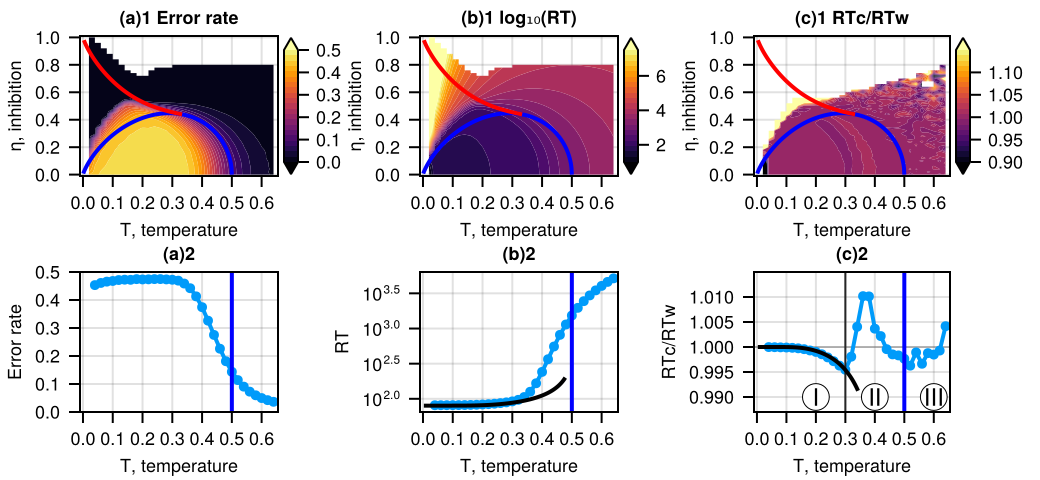

In [6]:
fig = Figure(size=(520, 240), fontsize=9, figure_padding=(3, 9, 3, 3)); ax = []; cf = []; #size=(510, 380)
begin
    push!(ax, Axis(fig[1, 1], xlabel="T, temperature", ylabel="η, inhibition", title="(a)1 Error rate"));
    push!(ax, Axis(fig[1, 3], xlabel="T, temperature", ylabel="η, inhibition", title="(b)1 log₁₀(RT)" ));
    push!(ax, Axis(fig[1, 5], xlabel="T, temperature", ylabel="η, inhibition", title="(c)1 RTc/RTw"   ));
    push!(ax, Axis(fig[2, 1], xlabel="T, temperature", ylabel="Error rate",    title="(a)2"));
    push!(ax, Axis(fig[2, 3], xlabel="T, temperature", ylabel="RT",            title="(b)2"));
    push!(ax, Axis(fig[2, 5], xlabel="T, temperature", ylabel="RTc/RTw",       title="(c)2")); 

    push!(cf, contourf!(ax[1], Ts, etas, error_hmap,      levels=range(0, 0.5,   length = 22), extendlow=:auto, extendhigh=:auto)); # 0.29:0.05:1.06, 
    push!(cf, contourf!(ax[2], Ts, etas, log10.(rt_hmap), levels=range(1, 7.5,   length = 22), extendlow=:auto, extendhigh=:auto)); # 0.88:0.05:1.23,
    push!(cf, contourf!(ax[3], Ts, etas, rtcw_hmap,       levels=range(0.9,1.15, length = 22), extendlow=:auto, extendhigh=:auto));

    [Colorbar(fig[1, 2*i], cf[i], size = 7) for i in 1:3];
    [lines!(axi, Tblue, ηblue, linewidth=2, color=:blue) for axi in ax[1:3]];  #  label="1-order tr-n", 
    [lines!(axi, Tred,  ηred,  linewidth=2, color=:red ) for axi in ax[1:3]];  #  label="2-order tr-n", 
    [xlims!(axi,[-0.01, Tmax+0.015]) for axi in ax]; 
    [ylims!(axi,[-0.01, maximum(etas)+0.01]) for axi in ax[1:3]]; [axi.yticks=0:0.2:1 for axi in ax[1:3]]
end
if true
    hlines!(ax[6], [1], linewidth=0.5, color=:grey50)
    
    scatterlines!(ax[4], TT_sim, err_sim,  markersize=7, linewidth=2, strokewidth=0.01, label = "simulation")
    scatterlines!(ax[5], TT_sim, rt_sim,   markersize=7, linewidth=2, strokewidth=0.01, )
    scatterlines!(ax[6], TT_sim, rtcw_sim, markersize=7, linewidth=2, strokewidth=0.01, )

    [vlines!(axi,   [0.5], linewidth=2, color=:blue) for axi in ax[4:6]]
    vlines!(ax[6],  [0.3], linewidth=1, color=:grey15)
    scatter!(ax[6], [0.2], [0.99], markersize=19, color=:white, strokewidth=0.5)
    scatter!(ax[6], [0.4], [0.99], markersize=19, color=:white, strokewidth=0.5)
    scatter!(ax[6], [0.6], [0.99], markersize=19, color=:white, strokewidth=0.5)
    text!(ax[6], [0.2; 0.4; 0.6], ones(3)*0.99, text=["I", "II", "III"], fontsize=12, align=(:center,:center), color=:black)

    ylims!(ax[4], [0, 0.5]);   ax[4].yticks=0:0.1:0.5;    
    ax[5].yscale=log10;        ylims!(ax[6], [0.987, 1.015]); 
end
begin
    error_th(η, T, ϵ1) = (1 + exp((η - ϵ1)/T)) / (1 + exp(η/T));
    error_th_lim(T, ϵ1) = exp(-ϵ1/T);
    error_th_V(η, T, ϵ1, VMF) = (1 + exp((-2*VMF+η-ϵ1)/T)) / (1 + exp((2*VMF+η)/T));
    VMF(V, T, η, ϵ1) = V - 1/4*sinh((4*V + ϵ1)/2/T) / (cosh((η + 2*V)/(2*T)) * cosh((-η + 2*V + ϵ1)/(2*T)));
    VMF_c(η, T, ϵ1) = fzero(V -> VMF(V, T, η, ϵ1),  0.45);
    VMF_w(η, T, ϵ1) = fzero(V -> VMF(V, T, η, ϵ1), -0.45);
    meanVMF(η, T, ϵ1) = (1-error_th(η, T, ϵ1))*VMF_c(η, T, ϵ1) + error_th(η, T, ϵ1)*VMF_w(η, T, ϵ1);
    RTrat_cw(η, T, ϵ1) = abs(VMF_w(η, T, ϵ1) / VMF_c(η, T, ϵ1));

    T_th = 0.003:0.005:0.48;     T_thcw_max = 0.345;
    η_th = 0;   ϵ1_th = ϵ1;
    RT_th_vec = [L / VMF_c(η_th, T, ϵ1) for T in T_th];
    RT_cw_th_vec = [RTrat_cw(η_th, T, ϵ1) for T in T_th];

    lines!(ax[5], T_th, RT_th_vec, color=:black, linewidth=2);
    lines!(ax[6], T_th[T_th .< T_thcw_max], RT_cw_th_vec[T_th .< T_thcw_max], color=:black, linewidth=2)
end
rowgap!(fig.layout, 3); colgap!(fig.layout, 3);# colgap!(fig.layout, 1, 5); 
colgap!(fig.layout, 2, -2); colgap!(fig.layout, 4, -2); 
fig

## RT distributions

In [7]:
numprocs = 4;
addprocs(numprocs);

In [8]:
function DecisionTrajectory_xvt(T::Number, η::Number, ϵk::AbstractVector, L::Number, numSpins::Integer, IC::String,
    x_init::Number, r0::Number, timemax::Number, dLcrossed::Number)
    # T - temperature
    # η - inhibition
    # ϵk - array of biases per target
    # L - threshold
    # numSpins - number of spins in one group (per target)
    # IC - initial condition of the active spins
    # x0 - initial position
    # r0 - units of rate
    # timemax - maximum time of the simulation
    # dLcrossed - distance to cut if finish far away from the target

    ## Initialization
    k = length(ϵk); # number of targets
    Pk = [1; -1]; #directions to the targets
    Vfunc(Nk::AbstractVector) = k==2 ? sum(Nk .* Pk)/(numSpins*k) : error("k is not 2!"); # velocity of the system

    Nk_cur = IC=="ZERO" ? zeros(Int8, k) : (IC=="RAND" ? [rand(1:numSpins) for i = 1:k] : error("IC is not valid!")); #[N1, N2, N3] - VEC kx1 define the current distribution of active spins (ON)
    x = x_init; # current position of the system
    v = Vfunc(Nk_cur); # current velocity of the system
    t = 0.0; # current time of the system
    dtrand = 0.0;

    x_seq = Array{Float64, 1}(); # positions of the system
    v_seq = Array{Float64, 1}(); # velocities of the system
    t_seq = Array{Float64, 1}(); # time of the system

    push!(x_seq, x); # save the initial position of the system
    push!(v_seq, v); # save the initial velocity of the system
    push!(t_seq, t); # save the initial time of the system
    ## Simulation
    while (abs(x) <= L)  # && (t < timemax)

        # on/off rates
        dH = (k .* v .* Pk .- η .+ ϵk);
        rk_on    = r0* (numSpins .- Nk_cur) ./ (1 .+ exp.( -dH/T )); # group 1...k: ++1
        rk_off   = r0* Nk_cur               ./ (1 .+ exp.(  dH/T )); # group 1...k: --1
        rates    = [rk_on; rk_off]; #array of rates for each target
        rate_tot = sum(rates); # total rate

        # choose a group to change and time interval
        rand_flip = 1 - rand(); # get a second random number

        # calculate next step: one spin flip occurs
        event = findfirst(rand_flip .<= cumsum(rates ./ rate_tot)); # find the event
        off_event = Int8(event > k); # determine the sign of the event: on=(ind<=k) or off=(ind>k)
        ind_event = event - k*off_event; # index of the event
        Nk_cur[ind_event] = Nk_cur[ind_event] + (-1)^off_event;

        # calculate the time interval
        rand_time = 1 - rand(); # get a random number for gillespie
        dtrand = (1/rate_tot) * log(1/rand_time); # calculate next time interval dt

        #update velocity and position according to the new spin distributions
        x += v * dtrand; # update the position of the system using previous velocity
        v = Vfunc(Nk_cur); # update the velocity of the system
        t += dtrand; # update the current time

        push!(x_seq, x); # save position 
        push!(v_seq, v); # save velocity
        push!(t_seq, t); # save time
    end

    #check if the motion finished too far from the threshold L
    if abs(x) - L > L*dLcrossed 
        if sign(x) > 0
            x = L;
            dx = L - x_seq[end-1]; #> 0
        else
            x = -L;
            dx = -L - x_seq[end-1]; #<0
        end
        t += -dtrand + dx / v_seq[end-1];
        t_seq[end] = t;
        x_seq[end] = x;
    end

    #t_seq .-= t_seq[end]; # set the decision time to zero
    return x_seq, v_seq, t_seq
end

DecisionTrajectory_xvt(T, η, ϵk, L, numSpins; IC="ZERO", x_init=0.0, r0=1.0, timemax=1e15, dLcrossed=1e-5) = 
DecisionTrajectory_xvt(T, η, ϵk, L, numSpins, IC, x_init, r0, timemax, dLcrossed)


DecisionTrajectory_xvt (generic function with 2 methods)

In [9]:
@everywhere begin
    import StatsBase: sample, mean, min, mode, max, std
    import Dates: now, Millisecond
    
    function DecisionTrajectory(T::Number, η::Number, ϵk::AbstractVector, L::Number, numSpins::Int, IC::String,
            x_init::Number, r0::Number, timemax::Number, dLcrossed::Number)
        # T - temperature
        # η - inhibition
        # ϵk - array of biases per target
        # L - threshold
        # numSpins - number of spins in one group (per target)
        # IC - initial condition of the active spins
        # x0 - initial position
        # r0 - units of rate
        # timemax - maximum time of the simulation
        # dLcrossed - distance to cut if finish far away from the target

        ## Initialization
        k = length(ϵk); # number of targets
        Pk = [1; -1]; #directions to the targets
        Vfunc(Nk::AbstractVector) = k==2 ? sum(Nk .* Pk)/(numSpins*k) : error("k is not 2!"); # velocity of the system

        Nk_cur = IC=="ZERO" ? zeros(Int8, k) : (IC=="RAND" ? [rand(1:numSpins) for i = 1:k] : error("IC is not valid!")); #[N1, N2, N3] - VEC kx1 define the current distribution of active spins (ON)
        x = x_init; # current position of the system
        v = Vfunc(Nk_cur); # current velocity of the system
        t = 0.0; # current time of the system
        dtrand = 0.0;
        v_next = v;
        x_prev = x;
        t_prev = t;

        #v_seq = Array{Float64, 1}(); # velocities of the system
        #push!(v_seq, v); # save the initial velocity of the system
        ## Simulation
        while (abs(x) ≤ L) && (t ≤ timemax)

            v = v_next;
            x_prev = x;
            t_prev = t;

            # on/off rates
            dH = (k .* v .* Pk .- η .+ ϵk);
            rk_on    = r0* (numSpins .- Nk_cur) ./ (1 .+ exp.( -dH/T )); # group 1...k: ++1
            rk_off   = r0* Nk_cur               ./ (1 .+ exp.(  dH/T )); # group 1...k: --1
            rates    = [rk_on; rk_off]; #array of rates for each target
            rate_tot = sum(rates); # total rate

            # choose a group to change and time interval
            rand_flip = 1 - rand(); # get a second random number

            # calculate next step: one spin flip occurs
            event = findfirst(rand_flip .<= cumsum(rates ./ rate_tot)); # find the event
            off_event = Int8(event > k); # determine the sign of the event: on=(ind<=k) or off=(ind>k)
            ind_event = event - k*off_event; # index of the event
            Nk_cur[ind_event] = Nk_cur[ind_event] + (-1)^off_event;

            # calculate the time interval
            rand_time = 1 - rand(); # get a random number for gillespie
            dtrand = (1/rate_tot) * log(1/rand_time); # calculate next time interval dt

            #update velocity and position according to the new spin distributions
            x += v * dtrand; # update the position of the system using previous velocity
            v_next = Vfunc(Nk_cur); # update the velocity of the system
            t += dtrand; # update the current time
            #push!(v_seq, v); # save the initial velocity of the system
        end

        #check if the motion finished too far from the threshold L
        if abs(x) - L > L*dLcrossed 
            if sign(x) > 0
                x = L;
                dx = L - x_prev; #> 0
            else
                x = -L;
                dx = -L - x_prev; #<0
            end
            t += -dtrand + dx / v;
        end

        return sign(x), t #, v_seq

    end
    DecisionTrajectory(T, η, ϵk, L, numSpins; IC="ZERO", x_init=0.0, r0=1.0, timemax=1e15, dLcrossed=1e-5) = 
    DecisionTrajectory(T, η, ϵk, L, numSpins, IC, x_init, r0, timemax, dLcrossed)

end

In [10]:
function print_properties(vec::AbstractVector, ndigits::Int)
    println("mean = $(round(mean(vec), digits=ndigit)), std = $(round(std(vec), digits=ndigit)), median = $(round(median(vec), digits=ndigit)), mode = $(round(mode(vec), digits=ndigit)), ")
    println("Skewness = $(round(skewness(vec), digits=ndigit)), Kurtosis = $(round(kurtosis(vec), digits=ndigit))")
end

print_properties (generic function with 1 method)

In [11]:
@everywhere begin
    findnearest(t::Number, A::AbstractArray) = findmin(abs.(A.-t))[2]; #find the position of t in A
    findnearest(vec::AbstractArray, A::AbstractArray) = [findmin(abs.(A.-t))[2] for t in vec]; #find the positions of elements of vec in A

    T_stars = [0.18, 0.3, 0.44]; η_stars = [0.45, 0.36, 0.56];
    bias_stars = [0.01, 0.01, 0.01];  ## ϵ1 (evidence)
end
round.(T_stars, digits=5), round.(η_stars, digits=5), round.(bias_stars, digits=5)

([0.18, 0.3, 0.44], [0.45, 0.36, 0.56], [0.01, 0.01, 0.01])

In [12]:
@everywhere begin
    L = 40; #threshold
    numSpins = 20; #number of spins per group
    dLcrossed = 1e-4; #distance to cut if finish far away from the target

    function simulate_RT(x, L, numSpins)
        #println(x)
        η = x[1];
        T = x[2];
        ϵ1 = x[3];
        ϵk = [ϵ1, 0]; #biases
        iterations = Int64(x[4]);
        #println("η = $(η), T = $T, iterations = $iterations")

        choices = fill(NaN, iterations);
        RTs     = fill(NaN, iterations);
        t1 = now();
        for iter in 1:iterations
            choice, rt = DecisionTrajectory(T, η, ϵk, L, numSpins);
            choices[iter] = choice == 1 ? 1 : 0;
            RTs[iter] = rt;
        end
        t2 = now();
        time_sec = (t2-t1)/Millisecond(1)*1e-3;
        println("η = $(η), T=$T, iterations=$iterations: $(time_sec) s, $(round(time_sec/60, digits=2)) min")
        #RTsc = RTs[choices .== 1]; RTsw = RTs[choices .== 0];
        return 1 - mean(choices), RTs, η, T, ϵ1, iterations #, std(RTs), RTsc, RTsw
    end
end

In [13]:
@everywhere begin
    F(T) = T*acosh((1-T)/T);
    
    T_eta_bias = [round.([T, η_stars[ind], bias_stars[ind]], digits=5) for (ind, T) in enumerate(T_stars)];
    iterations_ddm     = 1*10^3;   # 4*10^4;
    iterations_ordered = 2*10^4;   #   10^6
    iterations_interm  = 1*10^4;
    iterTeta(T, η, iterations_ordered, iterations_ddm) = T < 0.2 ? iterations_interm : T < 0.4 ? iterations_ordered : iterations_ddm;
end

@everywhere f(x) = simulate_RT(x, L, numSpins)

parameters_η_T_ϵ1_iter = [[x[2], x[1], x[3], iterTeta(x[1], x[2], iterations_ordered, iterations_ddm)] for x in T_eta_bias];
println((length(parameters_η_T_ϵ1_iter), length(parameters_η_T_ϵ1_iter) / numprocs))
parameters_η_T_ϵ1_iter

(3, 0.75)


3-element Vector{Vector{Float64}}:
 [0.45, 0.18, 0.01, 10000.0]
 [0.36, 0.3, 0.01, 20000.0]
 [0.56, 0.44, 0.01, 1000.0]

In [14]:
t1 = now();
raw_dataN = pmap(f, parameters_η_T_ϵ1_iter);  ## takes ~30s
t2 = now();
time_sec = (t2-t1)/Millisecond(1)*1e-3;
println("$(time_sec) s, $(round(time_sec/60, digits=2)) min, $(round(time_sec/60/60, digits=2)) h")

      From worker 2:	η = 0.45, T=0.18, iterations=10000: 4.313 s, 0.07 min
      From worker 3:	η = 0.36, T=0.3, iterations=20000: 23.97 s, 0.4 min
      From worker 4:	η = 0.56, T=0.44, iterations=1000: 53.233000000000004 s, 0.89 min
56.612 s, 0.94 min, 0.02 h


mean = 1.0, std = 0.65, median = 0.81, mode = 0.75, 
Skewness = 1.74, Kurtosis = 3.98
mean = 1.0, std = 0.56, median = 0.75, mode = 0.69, 
Skewness = 2.82, Kurtosis = 11.35
mean = 1.0, std = 0.23, median = 0.93, mode = 0.81, 
Skewness = 3.21, Kurtosis = 16.66


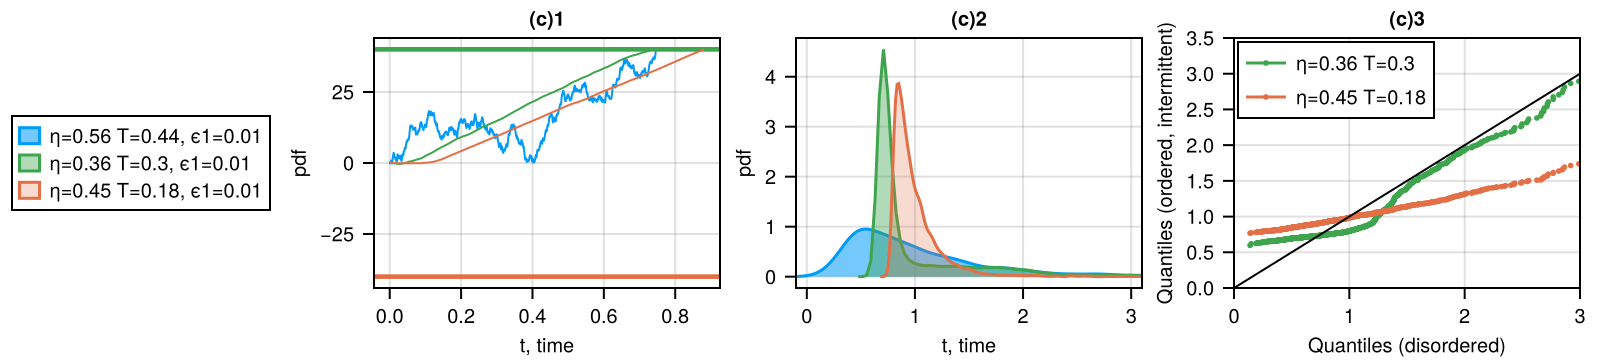

In [15]:
ndigits_r = 2; ndigit = 2;
VMF(V, T, η, ϵ1) = V - 1/4*sinh((4*V + ϵ1)/2/T) / (cosh((η + 2*V)/(2*T)) * cosh((-η + 2*V + ϵ1)/(2*T)));
#VMF_c = fzero(V -> VMF(V, T, η, ϵ1),  0.45);
#VMF_w = fzero(V -> VMF(V, T, η, ϵ1), -0.45);
data = [[], [], []];
t_traj_dist = []; x_traj_dist = []; v_traj_dist = [];
## compare distributions
fig = Figure(fontsize = 10, size=(200*4, 180), figure_padding=(3, 10, 3, 3)); ax = []; #400, 300 
push!(ax, Axis(fig[1,2], xlabel="t, time", ylabel="pdf", title="(c)1")); 
push!(ax, Axis(fig[1,3], xlabel="t, time", ylabel="pdf", title="(c)2")); 
push!(ax, Axis(fig[1,4], xlabel="Quantiles (disordered)", ylabel="Quantiles (ordered, intermittent)", title="(c)3")); 
for (ind, x) in enumerate(reverse(raw_dataN))
    error_rate, RTs, η, T, ϵ1, iterations = x;
    RTs_m = RTs ./ mean(RTs); data[ind] = RTs_m;

    density!(ax[2], RTs_m, npoints = 200, color=(c[ind], 0.7-0.15*ind), strokecolor=c[ind], strokewidth=1.5, label="η=$(η) T=$(T), ϵ1=$(ϵ1)")  
    print_properties(RTs_m, ndigits_r);

    hlines!(ax[1], [ L],  color=c[2], linewidth=2);
    hlines!(ax[1], [-L],  color=c[3], linewidth=2);
    x_vec, v_vec, t_vec = DecisionTrajectory_xvt(T, η, [ϵ1, 0], L, numSpins, dLcrossed=dLcrossed);
    if x_vec[end] < 0 x_vec = -x_vec; v_vec = -v_vec; end
    lines!(ax[1], t_vec ./ mean(RTs), x_vec, linewidth=1);
    push!(t_traj_dist, t_vec); push!(x_traj_dist, x_vec); push!(v_traj_dist, v_vec);
end 
[qqplot!(ax[3], data[1], data[ind], markersize = 4, color=c[ind], strokewidth=0.01, label="η=$(reverse(T_eta_bias)[ind][2]) T=$(reverse(T_eta_bias)[ind][1])") for ind in 2:3]
lines!(ax[3], 0:0.1:7, x -> x, color=:black, linewidth=1);
colgap!(fig.layout, 6); rowgap!(fig.layout, 8);  
axislegend(ax[3], position=:lt, height=40, rowgap=-3, width=100, margin=(2,0,0,2)) #, padding=(2,2,0,0))  #, margin=(2,0,0,0), padding=(2,2,0,0)
fig[1,1] = Legend(fig, ax[2], rowgap=2, margin=(3,3,3,3), padding=(4,4,4,4), patchsize=(10,8));
xlims!(ax[2], (-0.5, 5)); xlims!(ax[2], (-0.1, 3.1)); xlims!(ax[3], (0, 3)); ylims!(ax[3], (0, 3.5));  ##ax[1].yscale = pseudolog10
fig

## V distributions

In [16]:
findnearest(t::Number, A::AbstractArray) = findmin(abs.(A.-t))[2]; #find the position of t in A
findnearest(vec::AbstractArray, A::AbstractArray) = [findmin(abs.(A.-t))[2] for t in vec]; #find the positions of elements of vec in A

function DecisionTrajectory(T::Number, η::Number, ϵk::AbstractVector, L::Number, numSpins::Int, IC::String,
        x_init::Number, r0::Number, timemax::Number, dLcrossed::Number)
    # T - temperature
    # η - inhibition
    # ϵk - array of biases per target
    # L - threshold
    # numSpins - number of spins in one group (per target)
    # IC - initial condition of the active spins
    # x0 - initial position
    # r0 - units of rate
    # timemax - maximum time of the simulation
    # dLcrossed - distance to cut if finish far away from the target

    ## Initialization
    k = length(ϵk); # number of targets
    Pk = [1; -1]; #directions to the targets
    Vfunc(Nk::AbstractVector) = k==2 ? sum(Nk .* Pk)/(numSpins*k) : error("k is not 2!"); # velocity of the system

    Nk_cur = IC=="ZERO" ? zeros(Int8, k) : (IC=="RAND" ? [rand(1:numSpins) for i = 1:k] : error("IC is not valid!")); #[N1, N2, N3] - VEC kx1 define the current distribution of active spins (ON)
    x = x_init; # current position of the system
    v = Vfunc(Nk_cur); # current velocity of the system
    t = 0.0; # current time of the system
    dtrand = 0.0;
    v_next = v;
    x_prev = x;
    t_prev = t;

    v_seq = Array{Float64, 1}(); # velocities of the system
    push!(v_seq, v); # save the initial velocity of the system
    ## Simulation
    while (abs(x) ≤ L) && (t ≤ timemax)

        v = v_next;
        x_prev = x;
        t_prev = t;

        # on/off rates
        dH = (k .* v .* Pk .- η .+ ϵk);
        rk_on    = r0* (numSpins .- Nk_cur) ./ (1 .+ exp.( -dH/T )); # group 1...k: ++1
        rk_off   = r0* Nk_cur               ./ (1 .+ exp.(  dH/T )); # group 1...k: --1
        rates    = [rk_on; rk_off]; #array of rates for each target
        rate_tot = sum(rates); # total rate

        # choose a group to change and time interval
        rand_flip = 1 - rand(); # get a second random number

        # calculate next step: one spin flip occurs
        event = findfirst(rand_flip .<= cumsum(rates ./ rate_tot)); # find the event
        off_event = Int8(event > k); # determine the sign of the event: on=(ind<=k) or off=(ind>k)
        ind_event = event - k*off_event; # index of the event
        Nk_cur[ind_event] = Nk_cur[ind_event] + (-1)^off_event;

        # calculate the time interval
        rand_time = 1 - rand(); # get a random number for gillespie
        dtrand = (1/rate_tot) * log(1/rand_time); # calculate next time interval dt

        #update velocity and position according to the new spin distributions
        x += v * dtrand; # update the position of the system using previous velocity
        v_next = Vfunc(Nk_cur); # update the velocity of the system
        t += dtrand; # update the current time
        push!(v_seq, v); # save the initial velocity of the system
    end

    #check if the motion finished too far from the threshold L
    if abs(x) - L > L*dLcrossed 
        if sign(x) > 0
            x = L;
            dx = L - x_prev; #> 0
        else
            x = -L;
            dx = -L - x_prev; #<0
        end
        t += -dtrand + dx / v;
    end

    return sign(x), t, v_seq

end
DecisionTrajectory(T, η, ϵk, L, numSpins; IC="ZERO", x_init=0.0, r0=1.0, timemax=1e15, dLcrossed=1e-5) = 
DecisionTrajectory(T, η, ϵk, L, numSpins, IC, x_init, r0, timemax, dLcrossed)


DecisionTrajectory (generic function with 2 methods)

In [17]:
function DecisionTrajectory_xvt(T::Number, η::Number, ϵk::AbstractVector, L::Number, numSpins::Integer, IC::String,
        x_init::Number, r0::Number, timemax::Number, dLcrossed::Number)
    # T - temperature
    # η - inhibition
    # ϵk - array of biases per target
    # L - threshold
    # numSpins - number of spins in one group (per target)
    # IC - initial condition of the active spins
    # x0 - initial position
    # r0 - units of rate
    # timemax - maximum time of the simulation
    # dLcrossed - distance to cut if finish far away from the target

    ## Initialization
    k = length(ϵk); # number of targets
    Pk = [1; -1]; #directions to the targets
    Vfunc(Nk::AbstractVector) = k==2 ? sum(Nk .* Pk)/(numSpins*k) : error("k is not 2!"); # velocity of the system

    Nk_cur = IC=="ZERO" ? zeros(Int8, k) : (IC=="RAND" ? [rand(1:numSpins) for i = 1:k] : error("IC is not valid!")); #[N1, N2, N3] - VEC kx1 define the current distribution of active spins (ON)
    x = x_init; # current position of the system
    v = Vfunc(Nk_cur); # current velocity of the system
    t = 0.0; # current time of the system
    dtrand = 0.0;

    x_seq = Array{Float64, 1}(); # positions of the system
    v_seq = Array{Float64, 1}(); # velocities of the system
    t_seq = Array{Float64, 1}(); # time of the system

    push!(x_seq, x); # save the initial position of the system
    push!(v_seq, v); # save the initial velocity of the system
    push!(t_seq, t); # save the initial time of the system
    ## Simulation
    while (abs(x) <= L)  # && (t < timemax)

        # on/off rates
        dH = (k .* v .* Pk .- η .+ ϵk);
        rk_on    = r0* (numSpins .- Nk_cur) ./ (1 .+ exp.( -dH/T )); # group 1...k: ++1
        rk_off   = r0* Nk_cur               ./ (1 .+ exp.(  dH/T )); # group 1...k: --1
        rates    = [rk_on; rk_off]; #array of rates for each target
        rate_tot = sum(rates); # total rate

        # choose a group to change and time interval
        rand_flip = 1 - rand(); # get a second random number

        # calculate next step: one spin flip occurs
        event = findfirst(rand_flip .<= cumsum(rates ./ rate_tot)); # find the event
        off_event = Int8(event > k); # determine the sign of the event: on=(ind<=k) or off=(ind>k)
        ind_event = event - k*off_event; # index of the event
        Nk_cur[ind_event] = Nk_cur[ind_event] + (-1)^off_event;

        # calculate the time interval
        rand_time = 1 - rand(); # get a random number for gillespie
        dtrand = (1/rate_tot) * log(1/rand_time); # calculate next time interval dt

        #update velocity and position according to the new spin distributions
        x += v * dtrand; # update the position of the system using previous velocity
        v = Vfunc(Nk_cur); # update the velocity of the system
        t += dtrand; # update the current time

        push!(x_seq, x); # save position 
        push!(v_seq, v); # save velocity
        push!(t_seq, t); # save time
    end

    #check if the motion finished too far from the threshold L
    if abs(x) - L > L*dLcrossed 
        if sign(x) > 0
            x = L;
            dx = L - x_seq[end-1]; #> 0
        else
            x = -L;
            dx = -L - x_seq[end-1]; #<0
        end
        t += -dtrand + dx / v_seq[end-1];
        t_seq[end] = t;
        x_seq[end] = x;
    end

    #t_seq .-= t_seq[end]; # set the decision time to zero
    return x_seq, v_seq, t_seq
end

DecisionTrajectory_xvt(T, η, ϵk, L, numSpins; IC="ZERO", x_init=0.0, r0=1.0, timemax=1e15, dLcrossed=1e-5) = 
DecisionTrajectory_xvt(T, η, ϵk, L, numSpins, IC, x_init, r0, timemax, dLcrossed)

DecisionTrajectory_xvt (generic function with 2 methods)

In [18]:
## simulations take ~1 min
L = 40; #threshold
numSpins = 20; #number of spins per group
dLcrossed = 1e-4; #distance to cut if finish far away from the target

T = 0.29; #temperature
η = 0.44; #inhibition
ϵ1 = 0.01; ϵk = [ϵ1, 0]; #biases

itervmax = 2000; 
all_vel = Array{Float64,1}();
for iter in 1:itervmax
    choice, rt, v_vec = DecisionTrajectory(T, η, ϵk, L, numSpins);
    all_vel = [all_vel; v_vec];
end
F(V) = V - 1/4*sinh((4*V + ϵ1)/(2*T)) / (cosh((2*V + η)/(2*T)) * cosh((2*V - η + ϵ1)/(2*T)));
vel_mean_field_pos = find_zero(F, 0.5);   vel_mean_field_neg = find_zero(F, -0.5);  

all_vel_unbised = Array{Float64,1}();
for iter in 1:itervmax
    ϵk_unbised = [0, 0]; #biases
    choice, rt, v_vec = DecisionTrajectory(T, η, ϵk_unbised, L, numSpins);
    all_vel_unbised = [all_vel_unbised; v_vec];
end
F_unbiased(V) = V - 1/4*sinh((4*V)/(2*T)) / (cosh((2*V + η)/(2*T)) * cosh((2*V - η)/(2*T)));
vel_MF_unbiased_pos = find_zero(F_unbiased, 0.5);   vel_MF_unbiased_neg = find_zero(F_unbiased, -0.5);  

In [19]:
tc, vc, xc = [], [], []; flagc = 0;
tw, vw, xw = [], [], []; flagw = 0;
iter = 0;
while iter < itervmax
    x_vec, v_vec, t_vec = DecisionTrajectory_xvt(T, η, ϵk, L, numSpins, dLcrossed=dLcrossed);
    
    if flagw == 0 && x_vec[end] < 0
        tw, vw, xw = t_vec, v_vec, x_vec;
        flagw = 1;
    end
    if flagc == 0 && x_vec[end] > 0
        tc, vc, xc = t_vec, v_vec, x_vec;
        flagc = 1;
    end
    if flagc != 0 && flagw != 0
        break;
    end
    iter += 1;
end

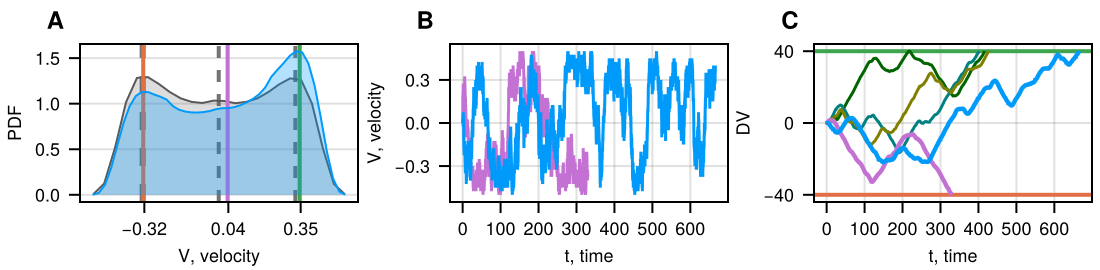

In [20]:
fig = Figure(size=(550, 135), fontsize=9, figure_padding=(3, 4, 3, 3)); ax = []; #400, 300 
    ga = fig[1,1] = GridLayout(); gb = fig[1,2] = GridLayout(); gc = fig[1,3] = GridLayout();
    push!(ax, Axis(fig[1,1], xlabel="V, velocity", ylabel="PDF"));  
    push!(ax, Axis(fig[1,2], xlabel="t, time", ylabel="V, velocity"));  
    push!(ax, Axis(fig[1,3], xlabel="t, time", ylabel="DV"));

lines!(ax[2], tw, vw, color=c[4],    linewidth=1.5);
lines!(ax[2], tc, vc, color=colblue, linewidth=1.5);
hlines!(ax[3], [L, -L], color=[c[2], c[3]], linewidth=2);

colii = [:darkgreen, :teal, :olive, :cadetblue]
flag = 0;
tcc_vec = []; vcc_vec = []; xcc_vec = [];
for ii in 1:100
    if flag == 3   break     end
    x_vec, v_vec, t_vec = DecisionTrajectory_xvt(T, η, ϵk, L, numSpins, dLcrossed=dLcrossed);
    if x_vec[end] > 0
        flag += 1;
        tcc, vcc, xcc = t_vec, v_vec, x_vec;
        push!(tcc_vec, tcc); push!(vcc_vec, vcc); push!(xcc_vec, xcc);
        lines!(ax[3], tcc, xcc, color=colii[flag], linewidth=1.5);
    end
end
lines!(  ax[3], tw, xw, color=c[4],    linewidth=2.2);
lines!(  ax[3], tc, xc, color=colblue, linewidth=2.2);
vlines!( ax[1], [vel_MF_unbiased_pos, vel_MF_unbiased_neg, mean(all_vel_unbised)], color=:grey45, linestyle=:dash, linewidth=[2,3,2])
density!(ax[1], sort(all_vel_unbised), npoints=24, color = (:grey35, 0.2), strokecolor=:grey35, strokewidth=1)
vlines!( ax[1], [vel_mean_field_pos, vel_mean_field_neg, mean(all_vel)], color=[c[2], c[3], c[4]], linewidth=2)
density!(ax[1], sort(all_vel), npoints = 42, color = (c[1], 0.3), strokecolor=c[1], strokewidth=1)

ax[1].xticks = round.([vel_mean_field_neg, vel_mean_field_pos, mean(all_vel)], digits=2)
    ax[3].yticks = [-L, 0, L];
    colgap!(fig.layout, 4); 
    linkxaxes!(ax[2], ax[3]);
    for (label, layout) in zip(["A", "B", "C", ], [ga, gb, gc])
        Label(layout[1, 1, TopLeft()], label,
                fontsize = 12,
                font = :bold,
                padding = (0, 8, 5, 0),
                halign = :right)
    end
    resize_to_layout!(fig)
fig

## Full

In [21]:
function add_box_inset(fig; bgcolor=:white, #snow2
    left=100, right=250, bottom=200, top=300, labelsize = 10, xlabel="", ylabel="")
    inset_box = Axis(fig, bbox=BBox(left, right, bottom, top), xlabel=xlabel, ylabel=ylabel, xticklabelsize=labelsize, yticklabelsize=labelsize, backgroundcolor=bgcolor)
    translate!(inset_box.scene, 0, 0, 100)  # bring content upfront
    hidedecorations!(inset_box, grid = true, label = false, ticklabels = false, ticks = false, minorgrid = false, minorticks = false)
    return inset_box
end

add_box_inset (generic function with 1 method)

η=0.56 T=0.44: VMF_cor = 0.01, RT_theory = 0.96, error_rate = 0.015
mean = 1.0, std = 0.65, median = 0.81, mode = 0.75, 
Skewness = 1.74, Kurtosis = 3.98
η=0.36 T=0.3: VMF_cor = 0.4, RT_theory = 0.65, error_rate = 0.392
mean = 1.0, std = 0.56, median = 0.75, mode = 0.69, 
Skewness = 2.82, Kurtosis = 11.35
η=0.45 T=0.18: VMF_cor = 0.47, RT_theory = 0.76, error_rate = 0.398
mean = 1.0, std = 0.23, median = 0.93, mode = 0.81, 
Skewness = 3.21, Kurtosis = 16.66


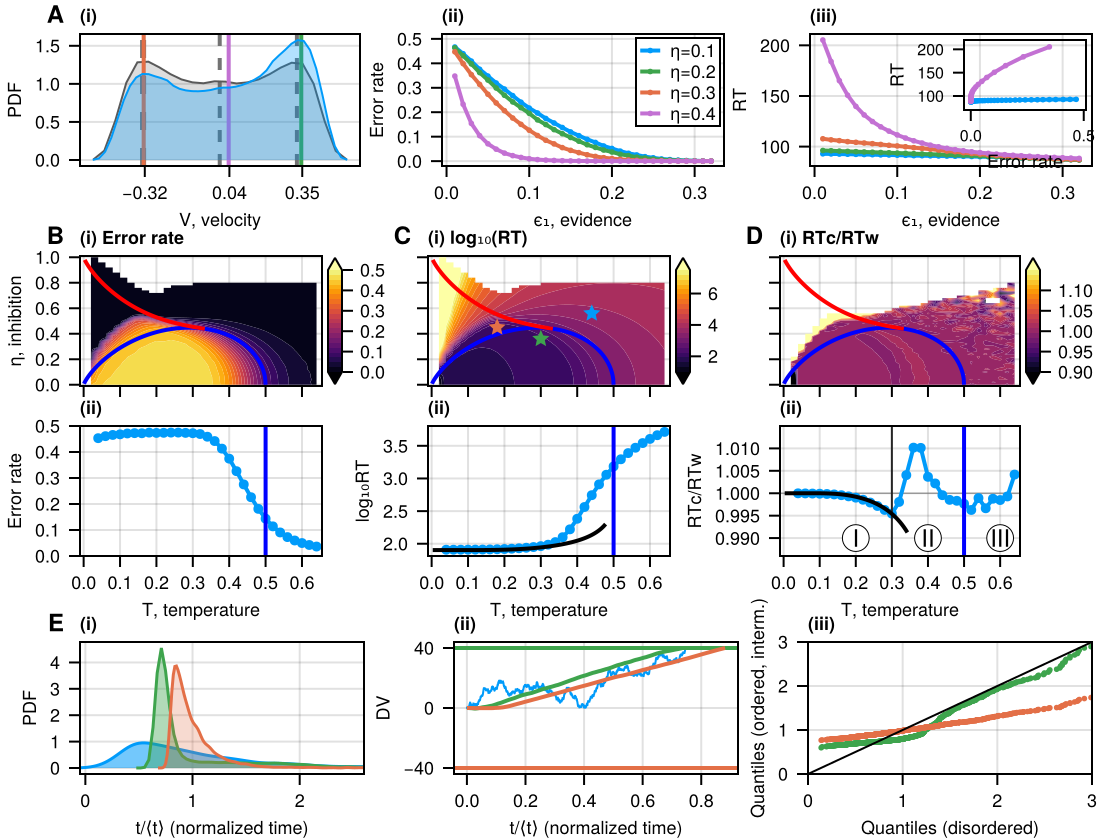

In [22]:
fig = Figure(size=(550, 420), fontsize=9, figure_padding=(3, 4, 2, 0)); ax = []; cf = []; #size=(510, 380)
begin  # A 1 2 3
    ga = fig[1,1:6] = GridLayout();
    push!(ax, Axis(ga[1,1], xlabel="V, velocity",  ylabel="PDF",               titlealign = :left, title = "(i)"));  
    push!(ax, Axis(ga[1,2], xlabel="ϵ₁, evidence", ylabel="Error rate",        titlealign = :left, title = "(ii)"));  
    push!(ax, Axis(ga[1,3], xlabel="ϵ₁, evidence", ylabel="RT", titlealign = :left, title = "(iii)"));

    vlines!( ax[1], [vel_MF_unbiased_pos, vel_MF_unbiased_neg, mean(all_vel_unbised)], color=:grey45, linestyle=:dash, linewidth=[2,3,2])
    density!(ax[1], sort(all_vel_unbised), npoints=24, color = (:grey35, 0.2), strokecolor=:grey35, strokewidth=1)
    vlines!( ax[1], [vel_mean_field_pos, vel_mean_field_neg, mean(all_vel)], color=[c[2], c[3], c[4]], linewidth=2)
    density!(ax[1], sort(all_vel), npoints = 42, color = (c[1], 0.3), strokecolor=c[1], strokewidth=1)
    ax[1].xticks = round.([vel_mean_field_neg, vel_mean_field_pos, mean(all_vel)], digits=2)
    
    biases_vec = 0.01:0.01:0.32; T_ERRT = 0.3;
    etas_show = 0.1:0.1:0.4;
    for η in etas_show
        df = df_raw[(df_raw.T .== T_ERRT) .&& (df_raw.eta .== η), :];
        error_vec = [mean(df[(df.bias .== bias), :].error) for bias in biases_vec];
        RT_vec    = [mean(df[(df.bias .== bias), :].rt)    for bias in biases_vec];
        #RT_vec = RT_vec ./ RT_vec[biases_vec .== 0]; # normalize RT
        scatterlines!(ax[2], biases_vec, error_vec,      markersize=4, linewidth=2, strokewidth=0.0, label="η=$(η)")
        scatterlines!(ax[3], biases_vec, RT_vec, markersize=4, linewidth=2, strokewidth=0.0, label="η=$(η)")
    end
    axislegend(ax[2], position=:rt, padding=(2,2,1,1), margin=(2,2,2,2), rowgap=0, patchsize=(10,6));
    linkxaxes!(ax[2], ax[3]); ylims!(ax[2], -0.02, 0.52); ax[2].yticks = 0:0.1:0.5; #xlims!(ax[2], 0, 0.33);
end
if true  # A inset_ax2
    inset_ax2 = add_box_inset(fig; bgcolor=(:white, 1), left=482, right=543, bottom=365, top=400, labelsize=8, 
                                    xlabel="Error rate", ylabel="RT");
    ind_show = [1, 4]
    for (ii, η) in zip(ind_show, etas_show[ind_show])
        df = df_raw[(df_raw.T .== T_ERRT) .&& (df_raw.eta .== η), :];
        error_vec = [mean(df[(df.bias .== bias), :].error) for bias in biases_vec];
        RT_vec    = [mean(df[(df.bias .== bias), :].rt)    for bias in biases_vec];
        scatterlines!(inset_ax2, error_vec, RT_vec, color=c[ii],  markersize=4, linewidth=2, strokewidth=0.0, label="η=$(η)")
    end
        xlims!(inset_ax2, -0.03, 0.51); inset_ax2.xticks = 0:0.5:1;  
        ylims!(inset_ax2, 70, 220); #inset_ax2.yticks = 0:0.5:1;
end
begin  # B C D 1
    ax=[];
    gb = fig[2:3, 1] = GridLayout();
    gc = fig[2:3, 3] = GridLayout();
    gd = fig[2:3, 5] = GridLayout();  
    push!(ax, Axis(fig[2,1], ylabel="η, inhibition", titlealign = :left, title = "(i) Error rate"))
    push!(ax, Axis(fig[2,3],                         titlealign = :left, title = "(i) log₁₀(RT)"));
    push!(ax, Axis(fig[2,5],                         titlealign = :left, title = "(i) RTc/RTw"));  
    push!(ax, Axis(fig[3,1], xlabel="T, temperature", ylabel="Error rate",    titlealign = :left, title = "(ii)"));       
    push!(ax, Axis(fig[3,3], xlabel="T, temperature", ylabel="log₁₀RT",            titlealign = :left, title = "(ii)"));  
    push!(ax, Axis(fig[3,5], xlabel="T, temperature", ylabel="RTc/RTw",       titlealign = :left, title = "(ii)"));       

    push!(cf, contourf!(ax[1], Ts, etas, error_hmap,      levels=range(0, 0.5,   length = 22), extendlow=:auto, extendhigh=:auto)); 
    push!(cf, contourf!(ax[2], Ts, etas, log10.(rt_hmap), levels=range(1, 7.5,   length = 22), extendlow=:auto, extendhigh=:auto)); 
    push!(cf, contourf!(ax[3], Ts, etas, rtcw_hmap,       levels=range(0.9,1.15, length = 22), extendlow=:auto, extendhigh=:auto));

    [Colorbar(fig[2,2*i], cf[i], size = 7, alignmode = Outside()) for i in 1:3];
    [lines!(axi, Tblue, ηblue, linewidth=2, color=:blue) for axi in ax[1:3]];  #  label="1-order tr-n", 
    [lines!(axi, Tred,  ηred,  linewidth=2, color=:red ) for axi in ax[1:3]];  #  label="2-order tr-n", 
    [xlims!(axi,[-0.01, Tmax+0.015]) for axi in ax]; 
    [ylims!(axi,[-0.01, maximum(etas)+0.01]) for axi in ax[1:3]]; [axi.yticks=0:0.2:1 for axi in ax[1:3]]

    [scatter!(ax[2], T_stars[ii], η_stars[ii], markersize=10, color=c[4-ii], marker=:star5, strokewidth=0.01) for ii in 1:3]
end
if true  # B C D 2
    hlines!(ax[6], [1], linewidth=0.5, color=:grey50)
    
    scatterlines!(ax[4], TT_sim, err_sim,  markersize=7, linewidth=2, strokewidth=0.01, label = "simulation")
    scatterlines!(ax[5], TT_sim, log10.(rt_sim),   markersize=7, linewidth=2, strokewidth=0.01, )
    scatterlines!(ax[6], TT_sim, rtcw_sim, markersize=7, linewidth=2, strokewidth=0.01, )

    [vlines!(axi,   [0.5], linewidth=2, color=:blue) for axi in ax[4:6]]
    vlines!(ax[6],  [0.3], linewidth=1, color=:grey15)
    scatter!(ax[6], [0.2], [0.99], markersize=19, color=:white, strokewidth=0.5)
    scatter!(ax[6], [0.4], [0.99], markersize=19, color=:white, strokewidth=0.5)
    scatter!(ax[6], [0.6], [0.99], markersize=19, color=:white, strokewidth=0.5)
    text!(ax[6], [0.2; 0.4; 0.6], ones(3)*0.99, text=["I", "II", "III"], fontsize=12, align=(:center,:center), color=:black)

    ylims!(ax[4], [0, 0.5]);   ax[4].yticks=0:0.1:0.5;    
    ylims!(ax[6], [0.986, 1.015]); 
    [hidexdecorations!(axi, label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false) for axi in ax[1:3]]
    [hideydecorations!(axi, label = false, ticklabels = true, ticks = false, grid = false, minorgrid = false, minorticks = false) for axi in ax[2:3]]
end
begin # B C D 2 RT_theory
    VMF(V, T, η, ϵ1) = V - 1/4*sinh((4*V + ϵ1)/2/T) / (cosh((η + 2*V)/(2*T)) * cosh((-η + 2*V + ϵ1)/(2*T)));
    VMF_c(η, T, ϵ1) = fzero(V -> VMF(V, T, η, ϵ1),  0.45);
    VMF_w(η, T, ϵ1) = fzero(V -> VMF(V, T, η, ϵ1), -0.45);
    #meanVMF(η, T, ϵ1) = (1-error_th(η, T, ϵ1))*VMF_c(η, T, ϵ1) + error_th(η, T, ϵ1)*VMF_w(η, T, ϵ1);
    RTrat_cw(η, T, ϵ1) = abs(VMF_w(η, T, ϵ1) / VMF_c(η, T, ϵ1));

    T_th = 0.003:0.005:0.48;     T_thcw_max = 0.345;
    η_th = 0;   ϵ1_th = ϵ1;
    RT_th_vec = [L / VMF_c(η_th, T, ϵ1) for T in T_th];
    RT_cw_th_vec = [RTrat_cw(η_th, T, ϵ1) for T in T_th];

    lines!(ax[5], T_th, log10.(RT_th_vec), color=:black, linewidth=2);
    lines!(ax[6], T_th[T_th .< T_thcw_max], RT_cw_th_vec[T_th .< T_thcw_max], color=:black, linewidth=2)
end
if true   # E 1 2 3
    ndigits_r = 2; labels_phases = ["Disordered", "Ordered", "Intermittent"];
    VMF(V, T, η, ϵ1) = V - 1/4*sinh((4*V + ϵ1)/2/T) / (cosh((η + 2*V)/(2*T)) * cosh((-η + 2*V + ϵ1)/(2*T)));
    data = [[], [], []]; col_vline = [:darkblue, :darkgreen, :darkred];
    ax = []; #400, 300 
        ge = fig[4, 1:6] = GridLayout();  
        push!(ax, Axis(ge[1,1], xlabel="t/⟨t⟩ (normalized time)", ylabel="PDF", titlealign = :left, title = "(i)")); 
        push!(ax, Axis(ge[1,2], xlabel="t/⟨t⟩ (normalized time)", ylabel="DV",  titlealign = :left, title = "(ii)")); 
        push!(ax, Axis(ge[1,3], xlabel="Quantiles (disordered)", ylabel="Quantiles (ordered, interm.)", titlealign = :left, title = "(iii)")); 
    for (ind, x) in enumerate(reverse(raw_dataN))
        error_rate, RTs, η, T, ϵ1, iterations = x;
        RTs_m = RTs ./ mean(RTs); data[ind] = RTs_m;
        VMF_cor = fzero(V -> VMF(V, T, η, ϵ1),  0.45); RT_theory = L / VMF_cor / mean(RTs);

        density!(ax[1], RTs_m, npoints = 200, color=(c[ind], 0.7-0.15*ind), strokecolor=c[ind], strokewidth=1.5 )#, label="η=$(η) T=$(T), ϵ1=$(ϵ1)")   
        
        println("η=$(η) T=$(T): VMF_cor = $(round(VMF_cor, digits=ndigits_r)), RT_theory = $(round(RT_theory, digits=ndigits_r)), error_rate = $(round(error_rate, digits=3))")
        print_properties(RTs_m, ndigits_r);

        hlines!(ax[2], [ L],  color=c[2], linewidth=2);
        hlines!(ax[2], [-L],  color=c[3], linewidth=2);
        x_vec = x_traj_dist[ind]; v_vec = v_traj_dist[ind]; t_vec = t_traj_dist[ind];
        if x_vec[end] < 0 x_vec = -x_vec; v_vec = -v_vec; end
        lines!(ax[2], t_vec ./ mean(RTs), x_vec, linewidth=ind==1 ? 1 : 2);
    end 
    [qqplot!(ax[3], data[1], data[ind], markersize = 4, color=c[ind], strokewidth=0.0, label="T=$(reverse(T_eta_bias)[ind][1])") for ind in 2:3]  
    lines!(ax[3], 0:0.1:7, x -> x, color=:black, linewidth=1);
    ax[2].yticks = -40:40:40; 
    xlims!(ax[1], (-0.5, 5)); xlims!(ax[1], (-0.05, 2.6)); xlims!(ax[3], (0, 3)); ylims!(ax[3], (0, 3));  ##ax[1].yscale = pseudolog10
end
if true   # colgap rowgap
    rowgap!(fig.layout, 0); colgap!(fig.layout, -15);
    rowgap!(fig.layout, 1, -3); rowgap!(fig.layout, 3, -5);
    colgap!(fig.layout, 1, 3);
    colgap!(fig.layout, 3, 3);
    colgap!(fig.layout, 5, 3);
    colgap!(ga, 4);  colgap!(ge, 5); 
end
for (label, layout) in zip(["A", "B", "C", "D", "E"], [ga, gb, gc, gd, ge])
    Label(layout[1, 1, TopLeft()], label,
            fontsize = 12,
            font = :bold,
            padding = (0, 8, 3, 0),
            halign = :right)
end
resize_to_layout!(fig)
fig